# Things to do
- EDA: inspect columns, handle missing data, define target
- Build baseline Logistic Regression model
- Add Decision Tree + Random Forest, compare scores
- Model selection + tuning (max_depth, n_estimators, etc.)
- Train final model & save with pickle
- Implement FastAPI service for inference
- Dockerize the app (Dockerfile)
- Test locally + via curl or Postman
- Optional cloud deploy (Render / Railway / Fly.io)

Questions:
- what does imbalanced data mean?

In [1]:
import pandas as pd
import numpy as np

from sklearn.tree import export_text

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_auc_score, accuracy_score

In [2]:
# import data
df = pd.read_csv('../data/diabetic_data.csv')

## Exploratory Data Analysis
- Inspect columns
- Handle missing data

### initial thoughts
- missing values with '?'- check their data types, and maybe fill with 0 or drop if missing values is a lot
- missing values with 'NAN'- check their data types, and maybe fill with NA or drop if missing values is a lot
- readmitted is the target variable, maybe convert to binary 0 and 1
- do I need to do some visualizations?

In [3]:
# Define the target variable: readmitted
# 'NO' → not readmitted
# '>30' → readmitted after 30 days
# '<30' → readmitted within 30 days

df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x=='<30' else 0 )

In [4]:
df.isna().sum()

encounter_id                    0
patient_nbr                     0
race                            0
gender                          0
age                             0
weight                          0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                      0
medical_specialty               0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [5]:
df = df.replace('?', np.nan)
df.isna().sum().sort_values(ascending=False)

weight                      98569
max_glu_serum               96420
A1Cresult                   84748
medical_specialty           49949
payer_code                  40256
race                         2273
diag_3                       1423
diag_2                        358
diag_1                         21
patient_nbr                     0
time_in_hospital                0
admission_source_id             0
num_lab_procedures              0
encounter_id                    0
admission_type_id               0
discharge_disposition_id        0
gender                          0
age                             0
number_inpatient                0
number_emergency                0
number_outpatient               0
num_medications                 0
num_procedures                  0
number_diagnoses                0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [6]:
# Drop columns with 30 to 90% null values
df = df.drop(columns=[
    'weight',
    'max_glu_serum',
    'A1Cresult',
    'medical_specialty',
    'payer_code'
], axis=1)

# Handle missing values and format categorical values
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include=['number']).columns

for c in cat_cols:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df[cat_cols] = df[cat_cols].fillna('NA')
df[num_cols] = df[num_cols].fillna(0.0)

In [7]:
df.columns.tolist()

['encounter_id',
 'patient_nbr',
 'race',
 'gender',
 'age',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'diag_1',
 'diag_2',
 'diag_3',
 'number_diagnoses',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'readmitted']

In [8]:
# Map age
age_map = {
    '[0-10)': 5,
    '[10-20)': 15,
    '[20-30)': 25,
    '[30-40)': 35,
    '[40-50)': 45,
    '[50-60)': 55,
    '[60-70)': 65,
    '[70-80)': 75,
    '[80-90)': 85,
    '[90-100)': 95
}
df['age'] = df['age'].map(age_map)

# Feature Engineering
### Will come back to this

In [9]:
df = df.drop(columns=['encounter_id', 'patient_nbr'], errors='ignore')

In [10]:
df.nunique().sort_values(ascending=False)

diag_3                      790
diag_2                      749
diag_1                      717
num_lab_procedures          118
num_medications              75
number_outpatient            39
number_emergency             33
discharge_disposition_id     26
number_inpatient             21
admission_source_id          17
number_diagnoses             16
time_in_hospital             14
age                          10
admission_type_id             8
num_procedures                7
race                          6
glyburide-metformin           4
metformin                     4
repaglinide                   4
nateglinide                   4
chlorpropamide                4
glimepiride                   4
glipizide                     4
pioglitazone                  4
glyburide                     4
acarbose                      4
rosiglitazone                 4
miglitol                      4
insulin                       4
gender                        3
tolazamide                    3
tolbutam

# Setting up the validation framework
#### Perform the train/validation/test split with Scikit-Learn

In [11]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [12]:
len(df_full_train)

81412

In [13]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)

In [14]:
y_train = df_train.readmitted.values
y_val = df_val.readmitted.values
y_test = df_test.readmitted.values

del df_train['readmitted']
del df_val['readmitted']
del df_test['readmitted']

In [15]:
df_full_train.readmitted.value_counts(normalize=True)

readmitted
0    0.887388
1    0.112612
Name: proportion, dtype: float64

In [16]:
df_full_train.readmitted.mean()

np.float64(0.11261239129366678)

In [17]:
num_cols

Index(['encounter_id', 'patient_nbr', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'readmitted'],
      dtype='object')

In [18]:
numerical = [
    'time_in_hospital',
    'num_lab_procedures',
    'num_procedures',
    'num_medications',
    'number_outpatient',
    'number_emergency',
    'number_inpatient',
    'number_diagnoses'
]

In [19]:
cat_cols

Index(['race', 'gender', 'age', 'diag_1', 'diag_2', 'diag_3', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed'],
      dtype='object')

# Feature Importance: 
- Readmission Rate
- Risk ratio
- Mutual information
- Correlation


### Readmission Rate
#### Best for Binary variables
Questions:
- Is feature importance only done on categorical variables?
- How does the mean rate tell us the important features?
- Should we do it on all features

In [20]:
global_readmitted = df_full_train.readmitted.mean()
global_readmitted

np.float64(0.11261239129366678)

In [21]:
readmitted_female = df_full_train[df_full_train.gender == 'female'].readmitted.mean()
readmitted_female

np.float64(0.11311752351383435)

In [22]:
readmitted_male = df_full_train[df_full_train.gender == 'male'].readmitted.mean()
readmitted_male

np.float64(0.11203297433851882)

In [23]:
global_readmitted - readmitted_female

np.float64(-0.0005051322201675701)

In [24]:
global_readmitted - readmitted_male

np.float64(0.00057941695514796)

### Risk Ratio
### Best for Categorical groups
Question: 
- what does the risk and diff tell us about these features

In [25]:
readmitted_female / global_readmitted

np.float64(1.0044855829306591)

In [26]:
readmitted_male / global_readmitted

np.float64(0.9948547673262974)

In [27]:
from IPython.display import display

In [28]:
#for c in cat_cols:
    # print(c)
    # df_group = df_full_train.groupby(c).readmitted.agg(['mean', 'count'])
    # df_group['diff'] = df_group['mean'] - global_readmitted
    # df_group['risk'] = df_group['mean'] / global_readmitted
    # display(df_group)
    # print()
    # print()

### Mutual information
### Best for Categorical groups
How much info a feature gives about target
- ✅ MI close to 0 → no info
- ✅ Higher MI → strong informative feature

In [29]:
from sklearn.metrics import mutual_info_score

In [30]:
def mutual_info_readmitted_score(series):
    return mutual_info_score(series, df_full_train.readmitted)

In [31]:
mi = df_full_train[cat_cols].apply(mutual_info_readmitted_score)
mi.sort_values(ascending=False)

diag_1                      8.969244e-03
diag_3                      8.143188e-03
diag_2                      7.503651e-03
insulin                     9.084641e-04
age                         5.814475e-04
diabetesMed                 4.114289e-04
metformin                   2.986104e-04
change                      1.700384e-04
race                        1.198009e-04
glipizide                   5.710555e-05
acarbose                    5.256147e-05
pioglitazone                4.801782e-05
repaglinide                 4.431814e-05
rosiglitazone               3.187767e-05
chlorpropamide              3.154034e-05
miglitol                    2.537009e-05
glyburide                   1.840014e-05
glimepiride                 1.602352e-05
glyburide-metformin         1.571878e-05
nateglinide                 1.537855e-05
gender                      5.865645e-06
tolbutamide                 4.334145e-06
metformin-rosiglitazone     2.935070e-06
troglitazone                2.935070e-06
tolazamide      

### Correlation
### Best for numerical features
- ➡️ High positive correlation → increases chance of readmission
- ➡️ High negative correlation → decreases it

In [32]:
df_full_train[numerical].corrwith(df_full_train.readmitted).abs()

time_in_hospital      0.044728
num_lab_procedures    0.019398
num_procedures        0.012659
num_medications       0.037057
number_outpatient     0.016453
number_emergency      0.059897
number_inpatient      0.166797
number_diagnoses      0.048522
dtype: float64

# One-hot encoding

In [33]:
numerical

['time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses']

In [34]:
dv = DictVectorizer(sparse=False)

In [35]:
train_dict = df_train[list(cat_cols) + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[list(cat_cols) + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

# Training Logistic Regression

In [36]:
model = LogisticRegression(solver='lbfgs')

model.fit(X_train, y_train)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [37]:
y_pred = model.predict_proba(X_val)[:, 1]

In [38]:
readmitted_decision = (y_pred >= 0.5)

In [39]:
# Accuracy
(y_val == readmitted_decision).mean()

np.float64(0.887633272736206)

In [40]:
# Coefficients
# Positive coefficient (+) ⇒ increases the chance of being readmitted

# Negative coefficient (−) ⇒ decreases the chance of readmission

feature_names = dv.get_feature_names_out()
coefs = model.coef_[0]
importance = sorted(zip(feature_names, coefs), key=lambda x: abs(x[1]), reverse=True)
importance[:10]

[('number_inpatient', np.float64(0.24554441753692352)),
 ('diabetesMed=no', np.float64(-0.1951111052170394)),
 ('diag_1=434', np.float64(0.18026873768211224)),
 ('change=ch', np.float64(-0.17921927235217283)),
 ('insulin=no', np.float64(-0.1638967091246426)),
 ('diag_2=250', np.float64(-0.156737405564199)),
 ('diag_3=401', np.float64(-0.15477725217671787)),
 ('nateglinide=no', np.float64(-0.153098836474299)),
 ('metformin=steady', np.float64(-0.15137360540453587)),
 ('diag_1=786', np.float64(-0.14735120787950357))]

## Evaluation of Logistic Regression

### Accuracy

In [41]:
C_grid = [0.01, 0.1, 1, 10, 100]
accuracies = []

for C in C_grid:

    # Create the model instance
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=1)
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    print(C)
    converted_decision = (y_pred >= 0.5)
    accuracy = (y_val == converted_decision).mean()
    accuracies.append({C: float(round(accuracy, 3))})

print(accuracies)

0.01
0.1
1
10
100
[{0.01: 0.888}, {0.1: 0.888}, {1: 0.888}, {10: 0.888}, {100: 0.888}]


### Confusion Matrix

In [42]:

cm = confusion_matrix(y_val, readmitted_decision)
cm


array([[18031,    31],
       [ 2256,    35]])

### Precision and Recall

In [43]:
precision = precision_score(y_val, readmitted_decision)

recall = recall_score(y_val, readmitted_decision)

print(f"Precision: {precision: .3f}")
print(f"Recall: {recall: .3f}")

Precision:  0.530
Recall:  0.015


### ROC Curve & AUC Score¨
0.5 = random guessing

1.0 = perfect model

0.8 = strong model

In [44]:
auc = roc_auc_score(y_val, y_pred)

print(f"AUC: {auc: .3f}")

AUC:  0.632


In [45]:
C_grid = [0.01, 0.1, 1, 10, 100]
scores = []

for C in C_grid:

    # Create the model instance
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=1)
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    print(C)
    converted_decision = (y_pred >= 0.5)
    accuracy = (y_val == converted_decision).mean()
    
    precision = precision_score(y_val, readmitted_decision)
    
    recall = recall_score(y_val, readmitted_decision)

    auc = roc_auc_score(y_val, y_pred)
    scores.append({
        'C': C,
        'accuracy': round(accuracy, 3),
        'precision': round(precision, 3),
        'recall': round(recall, 3),
        'auc': round(auc, 3)
    })

print(scores)

0.01
0.1
1
10
100
[{'C': 0.01, 'accuracy': np.float64(0.888), 'precision': 0.53, 'recall': 0.015, 'auc': 0.632}, {'C': 0.1, 'accuracy': np.float64(0.888), 'precision': 0.53, 'recall': 0.015, 'auc': 0.632}, {'C': 1, 'accuracy': np.float64(0.888), 'precision': 0.53, 'recall': 0.015, 'auc': 0.632}, {'C': 10, 'accuracy': np.float64(0.888), 'precision': 0.53, 'recall': 0.015, 'auc': 0.632}, {'C': 100, 'accuracy': np.float64(0.888), 'precision': 0.53, 'recall': 0.015, 'auc': 0.632}]


### Thresholds, plotting of graph, K-fold - come back to this

# Training Random Forest

In [ ]:
from IPython.display import display

In [48]:
scores = []

for n in range(10, 201, 10):
    print(n)
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200


In [49]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

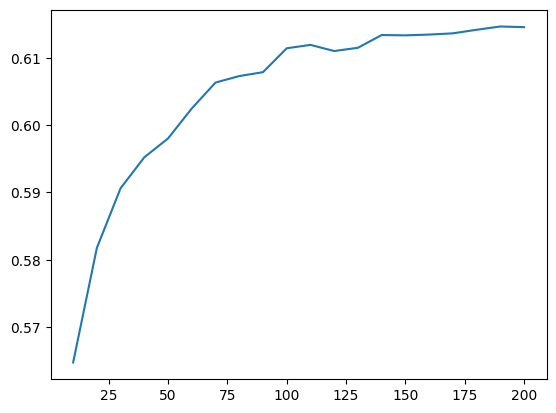

In [50]:
plt.plot(df_scores.n_estimators, df_scores.auc)